## Introduction

In [28]:
## Load in required packages

import_package = function(package_name){ ## function to suppress messages and warnings during package load
    suppressWarnings(suppressMessages(require(package_name, character.only = TRUE)))
}

import_package("nmecr")
import_package("ggplot2")

ERROR: Error in parse(text = x, srcfile = src): <text>:10:8: unexpected symbol
9: 
10: import warnings
           ^


## Read in Data

In [15]:
eload_data <- readRDS("Data/Processed Energy Consumption.rds")
temp_data <- readRDS("Data/Processed Temperature.rds")

In [23]:
message("Energy Consumption Data Summary:")
summary(eload_data)
message("Temperature Data Summary:")
summary(temp_data)

Energy Consumption Data Summary:



      time                         eload      
 Min.   :2020-03-31 00:00:00   Min.   :232.5  
 1st Qu.:2020-07-02 11:45:00   1st Qu.:333.3  
 Median :2020-10-03 23:30:00   Median :368.1  
 Mean   :2020-10-03 23:08:39   Mean   :390.5  
 3rd Qu.:2021-01-05 10:15:00   3rd Qu.:419.2  
 Max.   :2021-04-08 23:00:00   Max.   :693.0  

Temperature Data Summary:



      time                          temp      
 Min.   :2020-03-31 00:00:00   Min.   :42.84  
 1st Qu.:2020-07-01 12:15:00   1st Qu.:59.76  
 Median :2020-10-05 03:30:00   Median :66.02  
 Mean   :2020-10-04 06:57:11   Mean   :65.09  
 3rd Qu.:2021-01-06 12:45:00   3rd Qu.:70.13  
 Max.   :2021-04-08 23:00:00   Max.   :96.98  

In [24]:
energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2020-03-31",
                                          end_date = "2021-04-01", 
                                          convert_to_data_interval = "Daily")

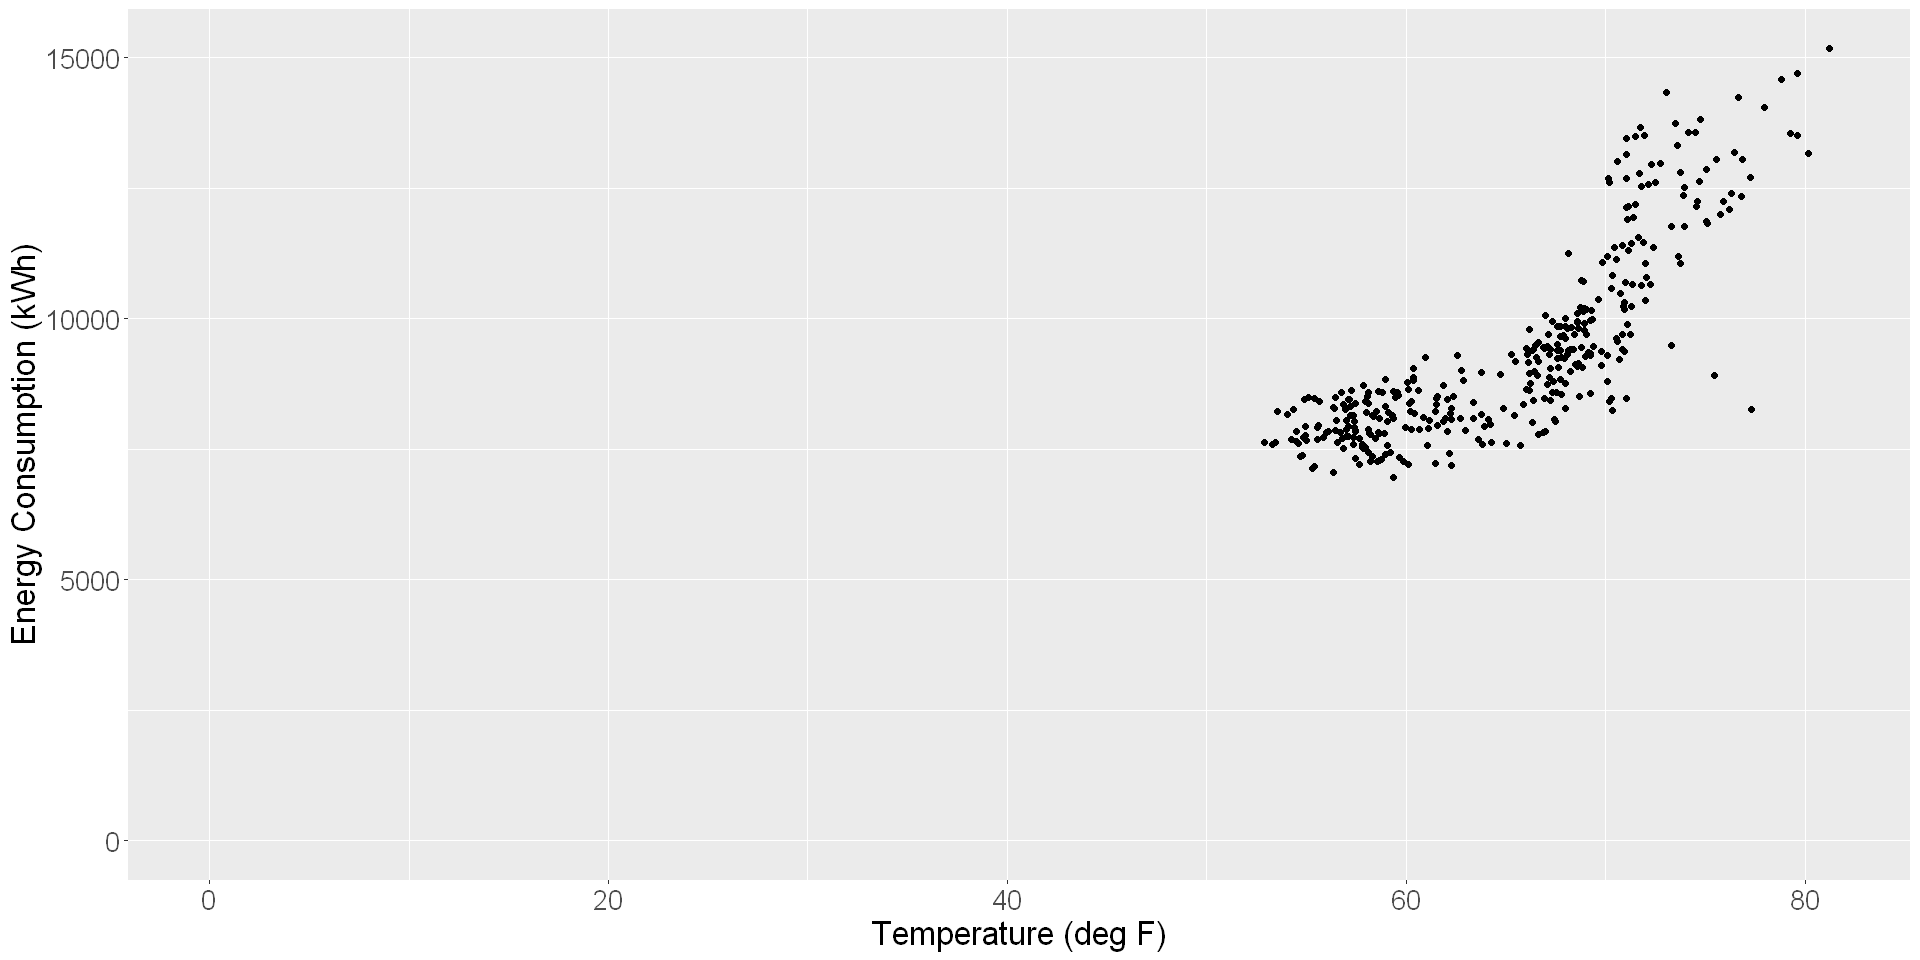

In [41]:
options(repr.plot.width=16, repr.plot.height=8)

energy_temp_df[complete.cases(energy_temp_df), ] %>%
    ggplot2::ggplot(aes(x = temp, y = eload)) +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    scale_y_continuous(limits = c(0, NA)) +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

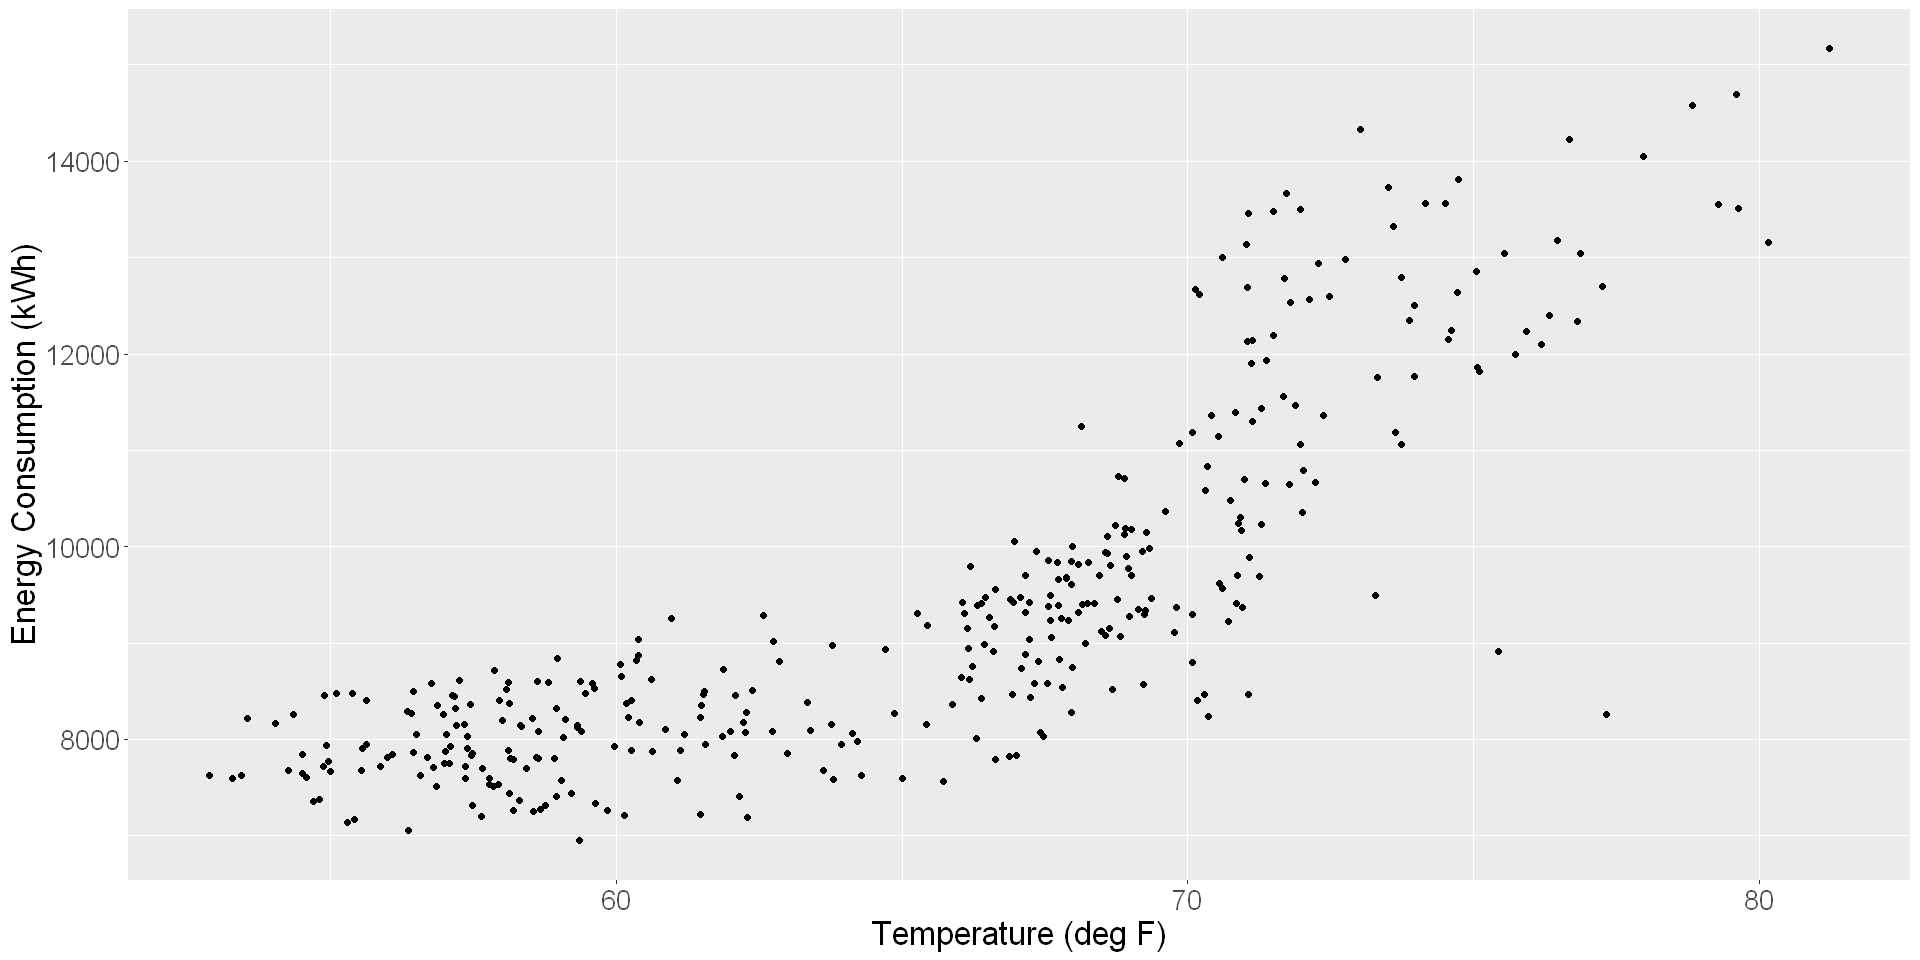

In [42]:
options(repr.plot.width=16, repr.plot.height=8)

energy_temp_df[complete.cases(energy_temp_df), ] %>%
    ggplot2::ggplot(aes(x = temp, y = eload)) +
    geom_point() +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

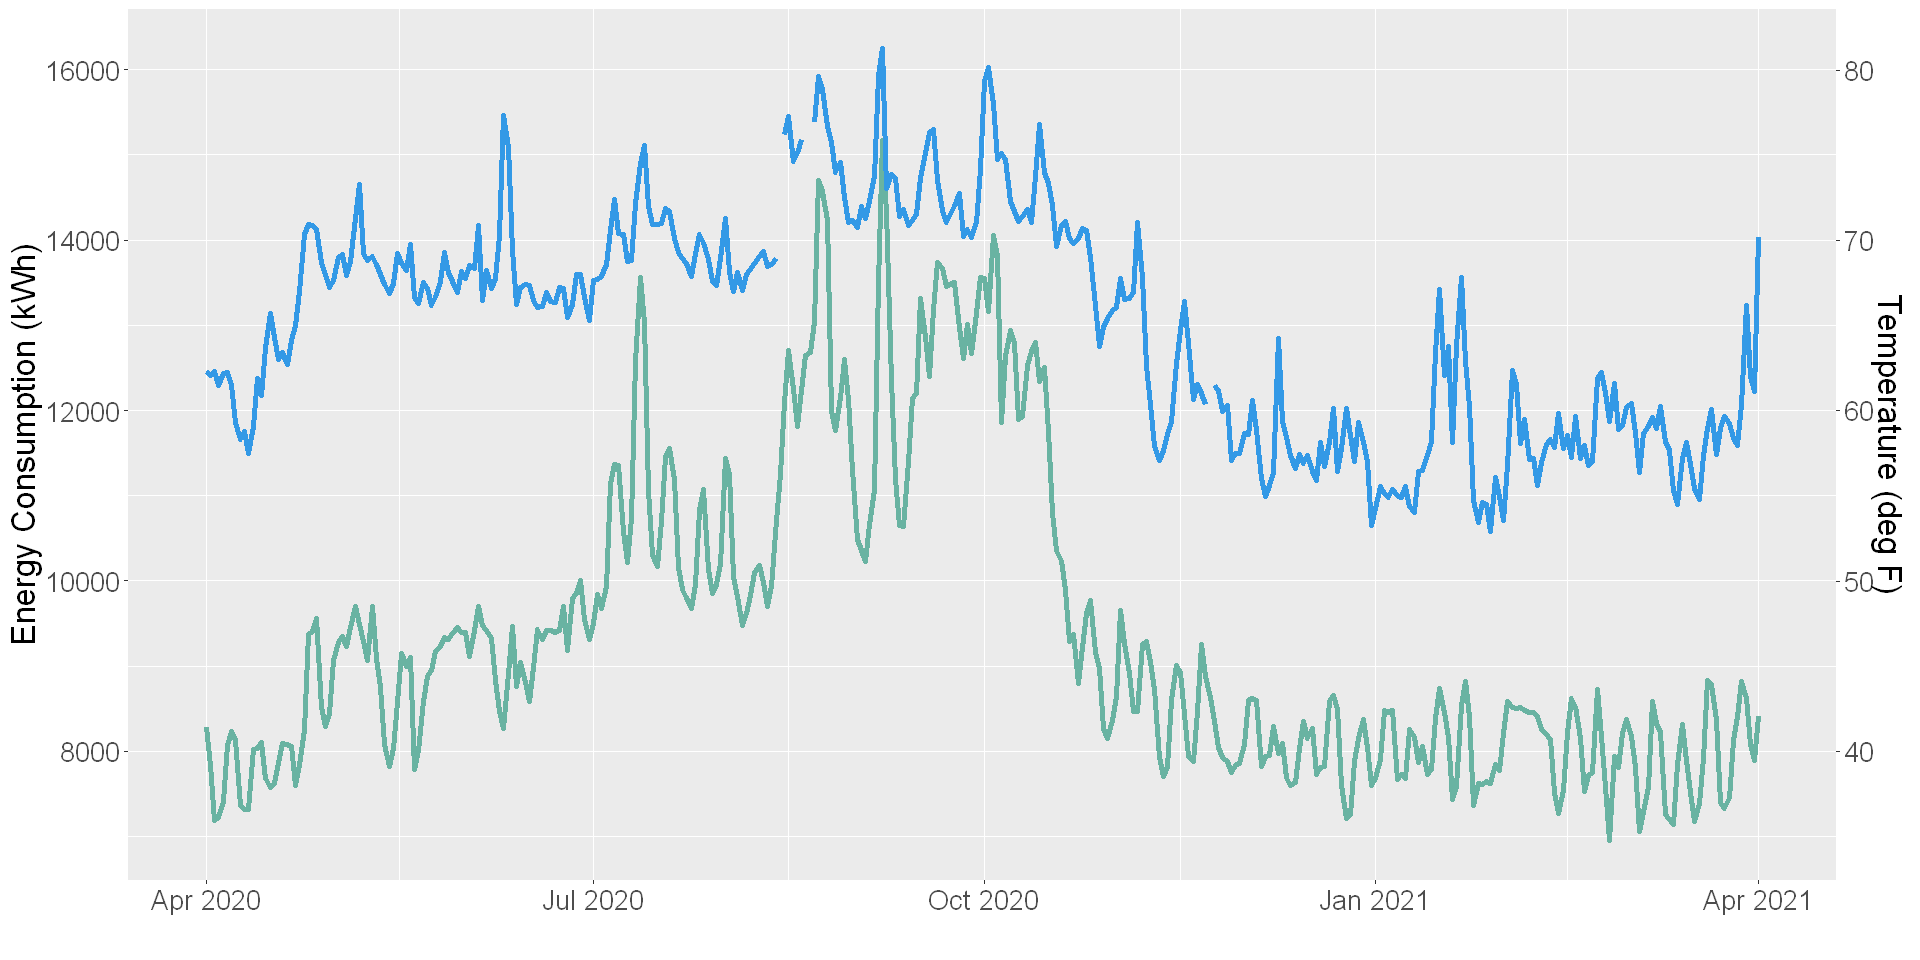

In [88]:
options(repr.plot.width=16, repr.plot.height=8)

energy_temp_line_df <- tidyr::pivot_longer(energy_temp_df,
                                           cols = c("eload", "temp"))

temperatureColor <- "#69b3a2"
priceColor <- rgb(0.2, 0.6, 0.9, 1)

energy_temp_df %>%
    ggplot2::ggplot(aes(x = time)) +
    geom_line(aes(y=eload), size=1.5, color=temperatureColor) + 
    geom_line( aes(y=temp*200), size=1.5, color=priceColor) +
    scale_y_continuous(
    name = "Energy Consumption (kWh)",    
    sec.axis = sec_axis(~.*1/200, name="Temperature (deg F)")) +
    theme(
    axis.title.y = element_text(size=20),
    axis.title.y.right = element_text(size=20),
    text = element_text(size = 20)) +
    xlab("") 

## 3PC vs TOWT

In [49]:
three_parameter_cooling_model <- nmecr::model_with_CP(training_data = energy_temp_df,
                                               model_input_options = nmecr::assign_model_inputs(regression_type = "3PC"))

TOWT_model <- nmecr::model_with_TOWT(training_data = energy_temp_df, 
                                     model_input_options = nmecr::assign_model_inputs(regression_type = "TOWT"))

actual_modeled_df <- three_parameter_cooling_model$training_data %>%
    select(-c("model_fit")) %>%
    mutate('CP_fit' = three_parameter_cooling_model$training_data$model_fit) %>%
    mutate('TOWT_fit' = TOWT_model$training_data$model_fit)

baseline_scatter_df <- tidyr::pivot_longer(actual_modeled_df,
                                           cols = c("eload", "CP_fit", "TOWT_fit"))

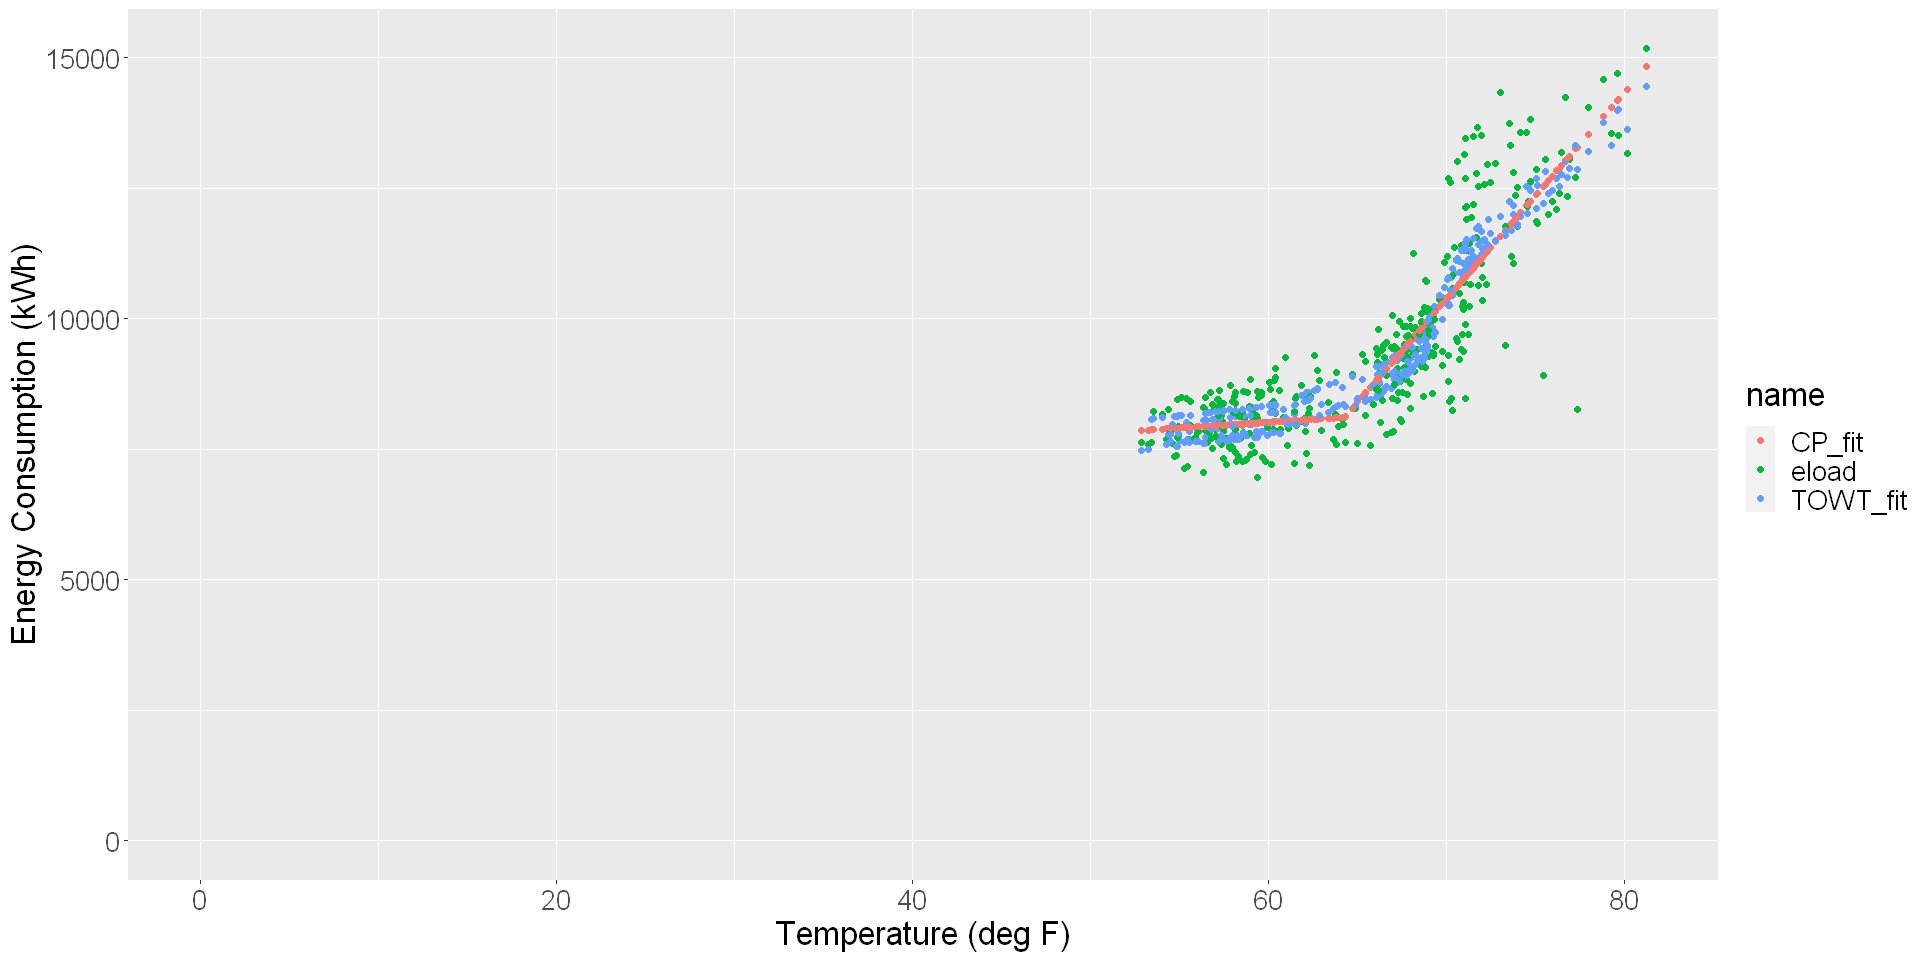

In [52]:
options(repr.plot.width=16, repr.plot.height=8)

baseline_scatter_df %>%
    ggplot2::ggplot(aes(x = temp, y = value, color = name)) +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    scale_y_continuous(limits = c(0, NA)) +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

In [92]:
## Summary Stats - 1

CP_stats <- nmecr::calculate_summary_statistics(three_parameter_cooling_model)
CP_unc <- nmecr::calculate_savings_and_uncertainty(modeled_object = three_parameter_cooling_model,
                                        model_summary_statistics = CP_stats,
                                        confidence_level = 90)

CP_metrics <- dplyr::bind_cols(CP_stats, CP_unc)

TOWT_stats <- nmecr::calculate_summary_statistics(TOWT_model)

TOWT_unc <- nmecr::calculate_savings_and_uncertainty(modeled_object = TOWT_model,
                                        model_summary_statistics = TOWT_stats,
                                        confidence_level = 90)

TOWT_metrics <- dplyr::bind_cols(TOWT_stats, TOWT_unc)

metrics <- dplyr::bind_rows(CP_metrics, TOWT_metrics)
metrics <- metrics[, c(1:5,9:10)]
names(metrics) <- c("R2", "Adj. R2", "CVRMSE%", "NDBE%", "NMBE%", 
                    "Savings Uncertainty @ 10% Savings", "Savings Fraction for 50% Uncertainty")

metrics$`NDBE%` <- as.numeric(metrics$`NDBE%`)
metrics$`NMBE%` <- as.numeric(metrics$`NMBE%`)

metrics

R2,Adj. R2,CVRMSE%,NDBE%,NMBE%,Savings Uncertainty @ 10% Savings,Savings Fraction for 50% Uncertainty
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.78,0.78,9.11,1.019202e-15,1.027719e-15,0.2771146,0.05542291
0.80,0.79,8.68,1.577082e-14,1.635827e-14,0.2841398,0.05682796


### Predictive Accuracy

In [93]:
eload_data <- readRDS("Data/Processed Energy Consumption - multiyear.rds")
temp_data <- readRDS("Data/Processed Temperature - multiyear.rds")

In [94]:
energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2020-03-31",
                                          end_date = "2021-04-01", 
                                          convert_to_data_interval = "Daily")

prediction_energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2019-03-31",
                                          end_date = "2020-03-30", 
                                          convert_to_data_interval = "Daily")

In [98]:
CP_prediction <- nmecr::calculate_model_predictions(training_data = energy_temp_df,
                                                           prediction_data = prediction_energy_temp_df,
                                                           modeled_object = three_parameter_cooling_model)

TOWT_prediction <- nmecr::calculate_model_predictions(training_data = energy_temp_df,
                                                           prediction_data = prediction_energy_temp_df,
                                                           modeled_object = TOWT_model)

all_predictions_df <- CP_prediction %>%
    select(-c("predictions")) %>%
    mutate('CP_predictions' = CP_prediction$predictions) %>%
    mutate('TOWT_predictions' = TOWT_prediction$predictions)

prediction_scatter_df <- tidyr::pivot_longer(all_predictions_df,
                                           cols = c("eload", "CP_predictions", "TOWT_predictions"))

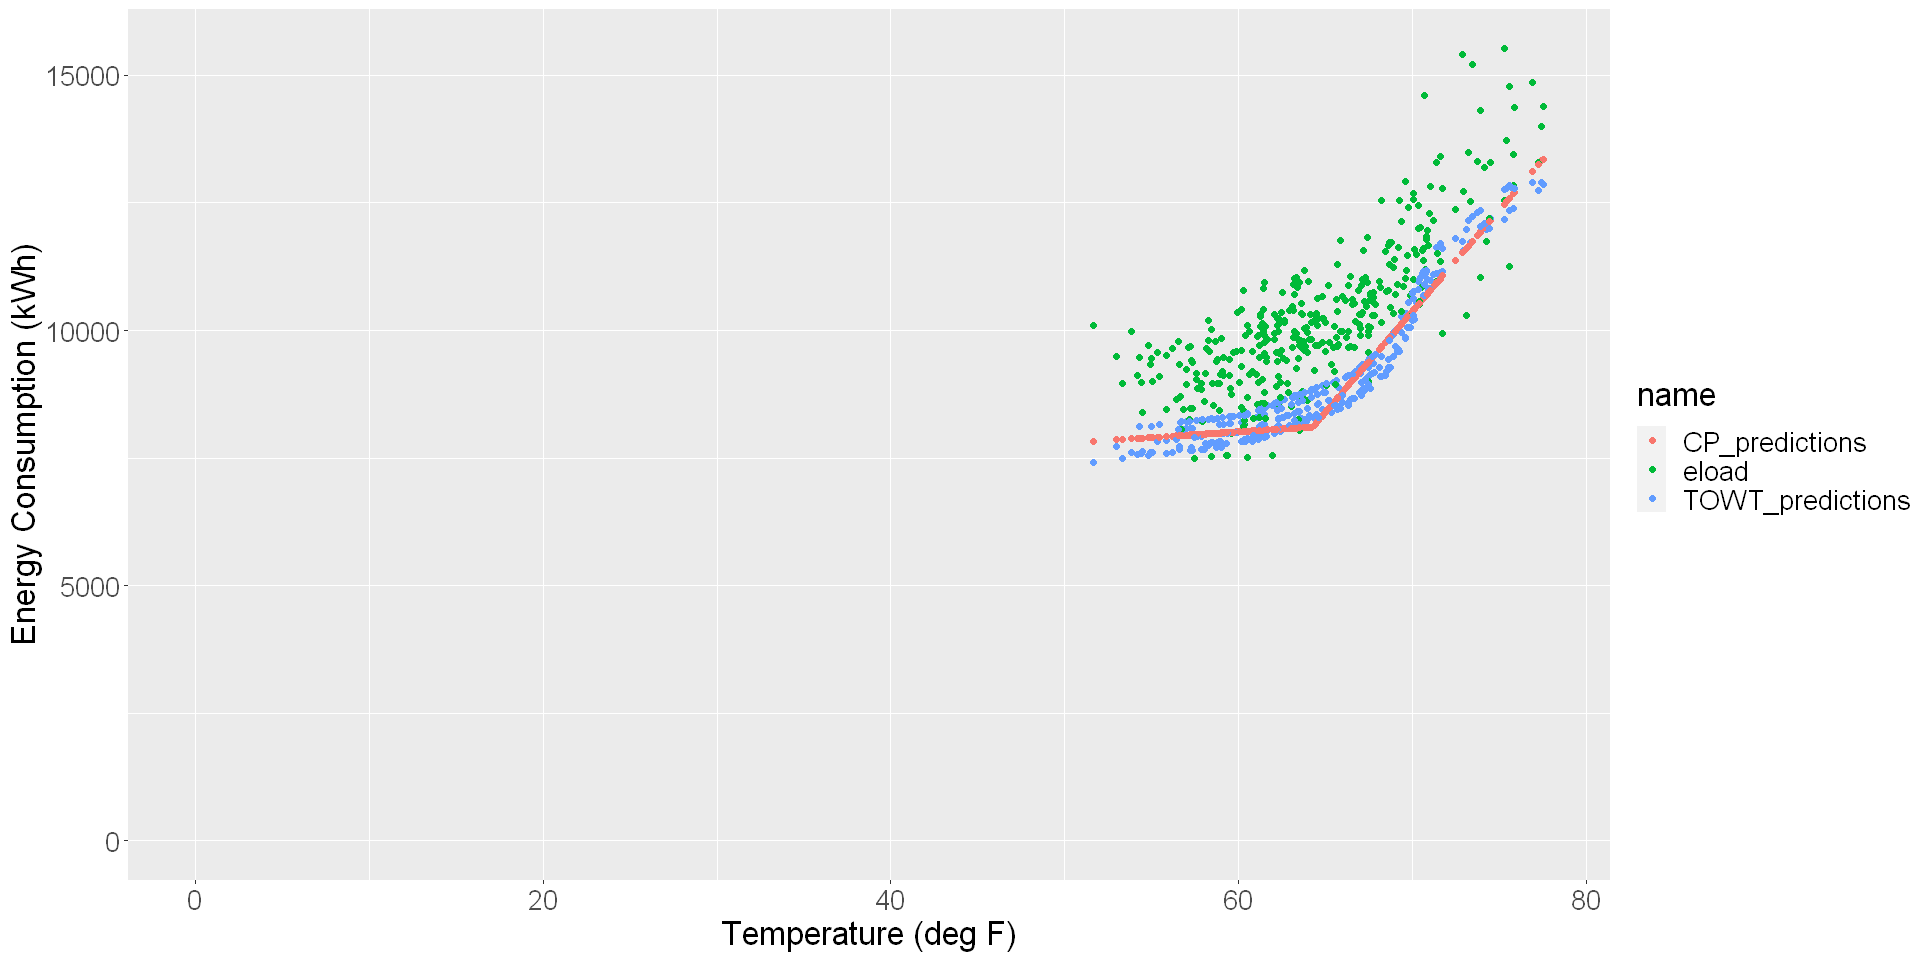

In [99]:
options(repr.plot.width=16, repr.plot.height=8)

prediction_scatter_df %>%
    ggplot2::ggplot(aes(x = temp, y = value, color = name)) +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    scale_y_continuous(limits = c(0, NA)) +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

In [117]:
CP_prediction_error <- sum(all_predictions_df$eload - all_predictions_df$CP_predictions, na.rm = T)/
                            sum(all_predictions_df$eload, na.rm = T)
TOWT_prediction_error <- sum(all_predictions_df$eload - all_predictions_df$TOWT_predictions, na.rm = T)/
                            sum(all_predictions_df$eload, na.rm = T)

CP_prediction_error <- paste0(round(100*CP_prediction_error, 2), "%")

TOWT_prediction_error <- paste0(round(100*TOWT_prediction_error, 2), "%")

message("Prediction Error using the Three Parameter cooling model is ", `CP_prediction_error`, 
        " while the error for the TOWT model is ", `TOWT_prediction_error`)

Prediction Error using the Three Parameter cooling model is 12.94% while the error for the TOWT model is: 12.21%



## Add in the occupancy variable

In [119]:
occupancy_data <- readRDS("Data/Processed Occupancy Data - multiyear.rds")

In [121]:
energy_temp_df_upd <- nmecr::create_dataframe(eload_data, temp_data, 
                                              additional_independent_variables = occupancy_data,
                                              additional_variable_aggregation = c(median),
                                              start_date = "2020-03-31",
                                              end_date = "2021-04-01", 
                                              convert_to_data_interval = "Daily")

prediction_energy_temp_df_upd <- nmecr::create_dataframe(eload_data, temp_data, 
                                                         additional_independent_variables = occupancy_data,
                                                         additional_variable_aggregation = c(median),
                                                         start_date = "2019-03-31",
                                                         end_date = "2020-03-30", 
                                                         convert_to_data_interval = "Daily")

In [122]:
three_parameter_cooling_model_upd <- nmecr::model_with_CP(training_data = energy_temp_df_upd,
                                               model_input_options = nmecr::assign_model_inputs(regression_type = "3PC"))

TOWT_model_upd <- nmecr::model_with_TOWT(training_data = energy_temp_df_upd, 
                                     model_input_options = nmecr::assign_model_inputs(regression_type = "TOWT"))

actual_modeled_df_upd <- three_parameter_cooling_model_upd$training_data %>%
    select(-c("model_fit")) %>%
    mutate('CP_fit' = three_parameter_cooling_model_upd$training_data$model_fit) %>%
    mutate('TOWT_fit' = TOWT_model_upd$training_data$model_fit)

baseline_scatter_df_upd <- tidyr::pivot_longer(actual_modeled_df_upd,
                                           cols = c("eload", "CP_fit", "TOWT_fit"))

In [56]:
updated_predictions <- nmecr::calculate_model_predictions(training_data = baseline_df,
                                                           prediction_data = updated_prediction_df,
                                                           modeled_object = baseline_model)

Warning message:
"Removed 670 row(s) containing missing values (geom_path)."


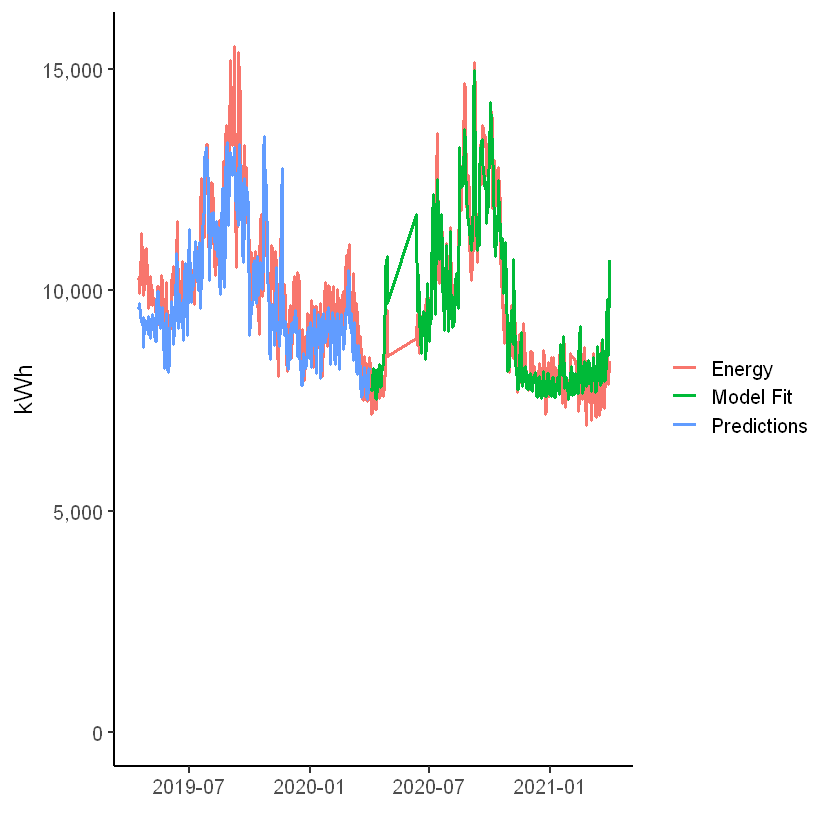

In [57]:
all_data <- dplyr::bind_rows(baseline_model$training_data,
                             updated_predictions)


all_data_ts_df <- all_data[, c("eload", "time", "predictions", "model_fit")]
names(all_data_ts_df) <- c("Energy", "Time", "Predictions", "Model Fit")
all_data_ts_df <- tidyr::pivot_longer(all_data_ts_df,
                                         cols = c("Energy", "Predictions", "Model Fit"))

ggplot2::ggplot(all_data_ts_df) +
  aes(x = Time, y = value, color = name) +
  geom_line(size = 1) +
  scale_y_continuous(limits = c(0, NA), labels = scales::comma) + ylab("kWh") +
  xlab("") +
  # scale_color_manual(values = c("#E76B15", "#D9D50B")) +
  theme_classic(base_size = 15) + theme(legend.title = element_blank())

In [59]:
summary.lm(baseline_model$model_unoccupied)


Call:
lm(formula = training_data$eload ~ ., data = dframe_unocc, subset = !ok_occ, 
    weights = model_input_options$train_weight_vec, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-2806.5  -379.1     9.1   447.9  2076.6 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7979.646   3698.881   2.157   0.0318 *  
pct_occupancy 1514.848    183.162   8.271 4.18e-15 ***
ftow2          290.719    147.599   1.970   0.0498 *  
ftow3          311.562    150.570   2.069   0.0394 *  
ftow4          111.145    151.820   0.732   0.4647    
ftow5         -135.694    151.221  -0.897   0.3703    
ftow6         -194.202    150.992  -1.286   0.1994    
ftow7         -182.262    143.993  -1.266   0.2066    
X1              -5.256     65.953  -0.080   0.9365    
X2              64.515     82.224   0.785   0.4333    
X3              35.293     47.434   0.744   0.4574    
X4             305.646     51.216   5.968 6.67e-09 ***
X5             